In [27]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ann challenge

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ann challenge


## Import Libraries


In [28]:
# Fix randomness and hide warnings
original_seed = 42
seed = original_seed

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [29]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [30]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import shuffle, resample
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import seaborn as sns
sns.set_theme()

## Load Data

In [31]:
!unzip -qu "public_data.zip" -d "/content"

In [32]:
files = np.load("/content/public_data.npz", allow_pickle=True)

In [33]:
files["data"].shape, files["labels"].shape

((5200, 96, 96, 3), (5200,))

In [34]:
X_data = files["data"]

In [35]:
y_data = files["labels"]

## Inspect Data

In [36]:
np.unique(y_data, return_counts=True)

(array(['healthy', 'unhealthy'], dtype=object), array([3199, 2001]))

In [37]:
start_index = 0
def visualize_images(X, start_index, num_images: int = 10) -> None:
    plt.figure(figsize=(16, 16))
    for i in range(num_images**2):
        _ = plt.subplot(num_images, num_images, i + 1)
        plt.imshow(X[start_index+i].astype(np.uint8))
        plt.title(f'{y_data[start_index+i]} [{start_index+i}]', fontsize=8)
        plt.axis("off")
    plt.show()

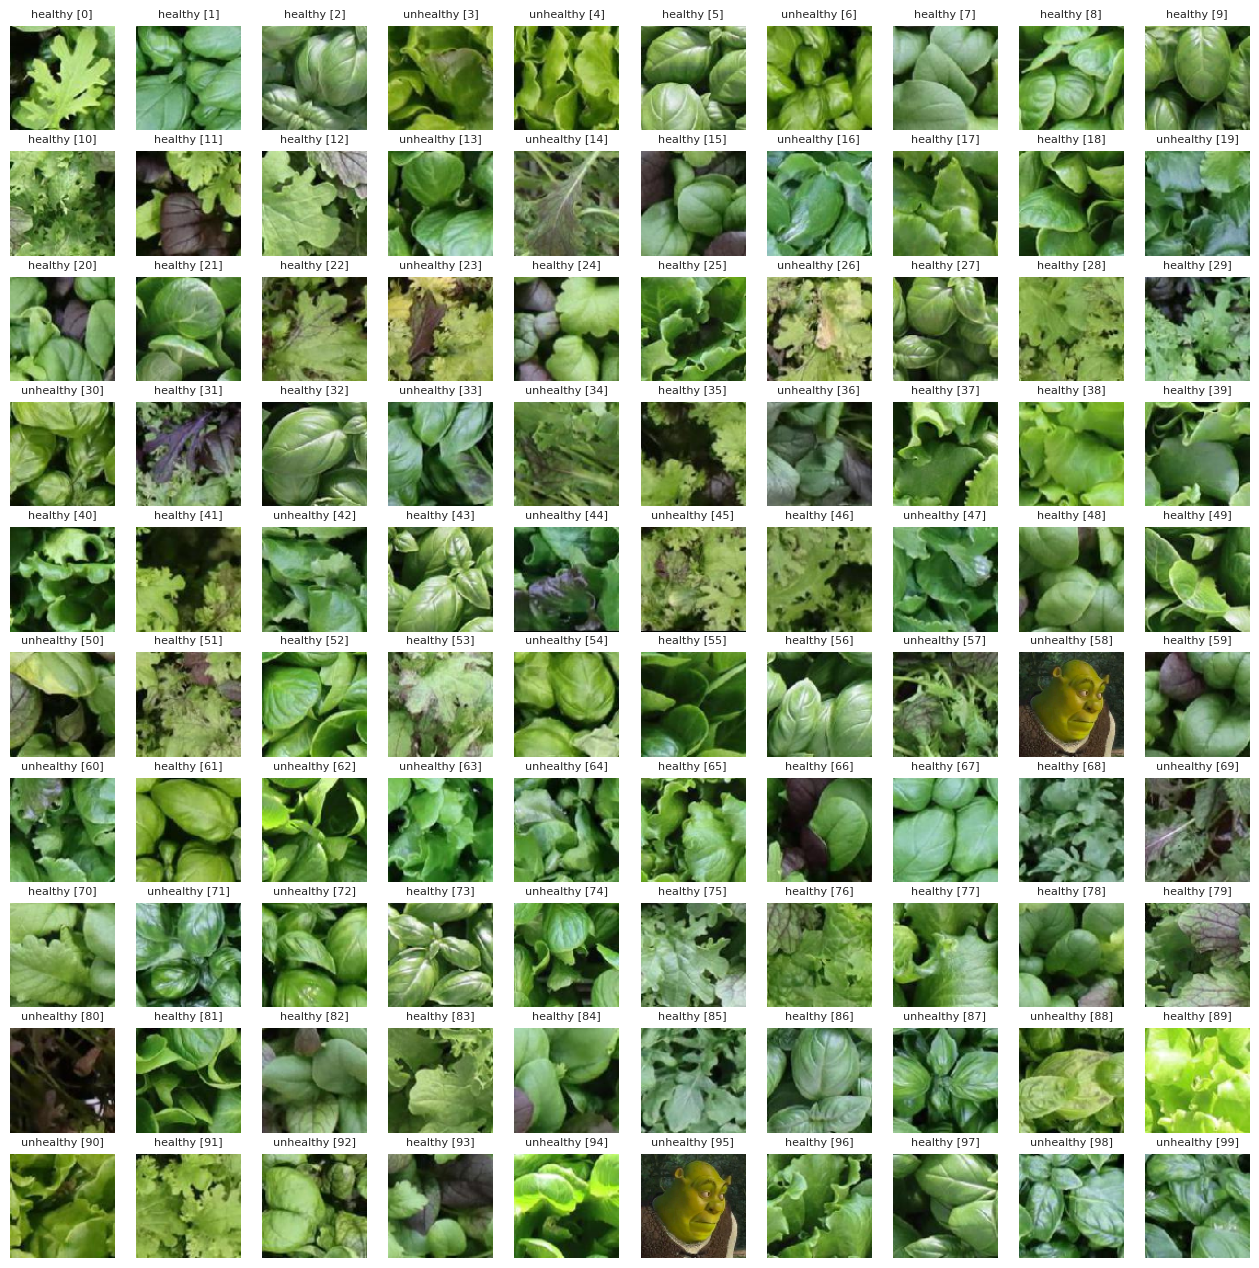

In [38]:
visualize_images(X_data, start_index)
start_index += 100

In [39]:
to_delete = [58, 95, 137, 138, 171, 207, 338, 412, 434, 486, 506, 529, 571, 599, 622, 658, 692, 701, 723, 725, 753, 779, 783, 827, 840, 880, 898, 901, 961, 971, 974, 989, 1028, 1044, 1064, 1065, 1101, 1149, 1172, 1190, 1191, 1265, 1268, 1280, 1333, 1384, 1443, 1466, 1483, 1528, 1541, 1554, 1594, 1609, 1630, 1651, 1690, 1697, 1752, 1757, 1759, 1806, 1828, 1866, 1903, 1938, 1939, 1977, 1981, 1988, 2022, 2081, 2090, 2150, 2191, 2192, 2198, 2261, 2311, 2328, 2348, 2380, 2426, 2435, 2451, 2453, 2487, 2496, 2515, 2564, 2581, 2593, 2596, 2663, 2665, 2675, 2676, 2727, 2734, 2736, 2755, 2779, 2796, 2800, 2830, 2831, 2839, 2864, 2866, 2889, 2913, 2929, 2937, 3033, 3049, 3055, 3086, 3105, 3108, 3144, 3155, 3286, 3376, 3410, 3436, 3451, 3488, 3490, 3572, 3583, 3666, 3688, 3700, 3740, 3770, 3800, 3801, 3802, 3806, 3811, 3821, 3835, 3862, 3885, 3896, 3899, 3904, 3927, 3931, 3946, 3950, 3964, 3988, 3989, 4049, 4055, 4097, 4100, 4118, 4144, 4150, 4282, 4310, 4314, 4316, 4368, 4411, 4475, 4476, 4503, 4507, 4557, 4605, 4618, 4694, 4719, 4735, 4740, 4766, 4779, 4837, 4848, 4857, 4860, 4883, 4897, 4903, 4907, 4927, 5048, 5080, 5082, 5121, 5143, 5165, 5171]

In [40]:
X_clean = np.delete(X_data, to_delete, axis=0)
y_clean = np.delete(y_data, to_delete, axis=0)

In [41]:
print(X_clean.shape)
print(y_clean.shape)

(5004, 96, 96, 3)
(5004,)


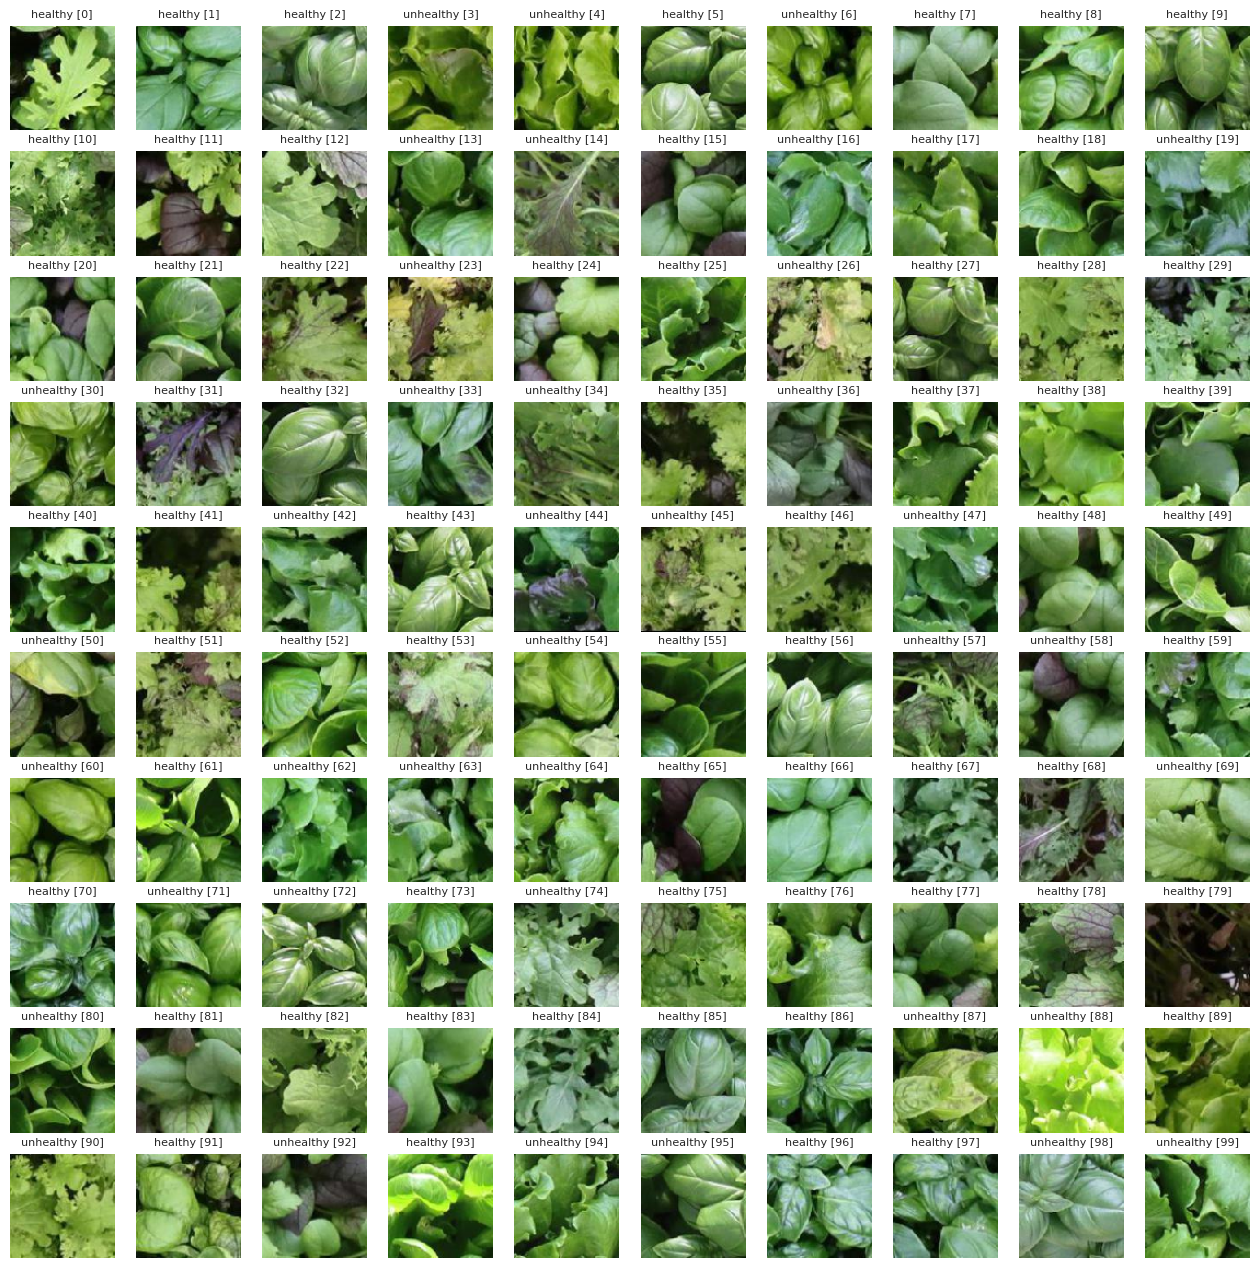

In [42]:
visualize_images(X_clean, start_index=0)

In [43]:
# Check if the cleaned data is balanced
unique, count = np.unique(y_clean, return_counts=True)
print("Labels:", unique)
for i in range(unique.size):
  print(f"Class '{unique[i]}' has {count[i]} samples")

Labels: ['healthy' 'unhealthy']
Class 'healthy' has 3101 samples
Class 'unhealthy' has 1903 samples


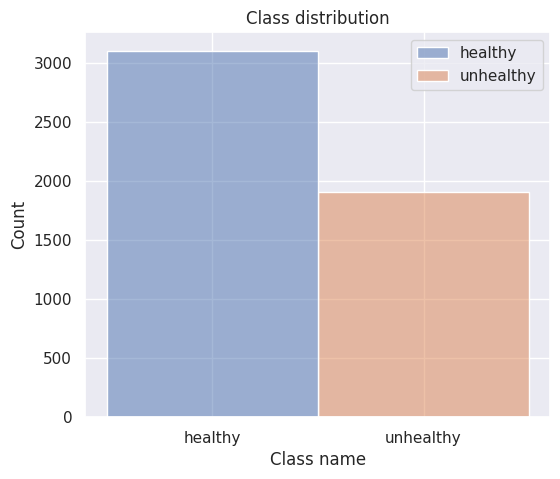

In [44]:
# Plot the class distribution
plt.figure(figsize=(6, 5))
sns.histplot(x=y_clean, hue=y_clean, binwidth=0.5)
plt.xticks([0, 1], ['healthy', 'unhealthy'])
plt.title('Class distribution')
plt.xlabel('Class name')
plt.ylabel('Count');

## Process Data

In [45]:
# X_norm = (X_clean / 255)

In [46]:
# One-Hot encoding for the labels
one_hot_encoder = OneHotEncoder(sparse = False)
y_encoded = one_hot_encoder.fit_transform(y_clean.reshape(-1,1))

In [47]:
# # Label encoding
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y_clean)

### Split 80%-20%

In [48]:
seed = original_seed

In [49]:
def split(X, y, seed):
  # Split data into training and validation sets, maintaining class distribution
  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2, stratify=y)

  # Print the shapes of the resulting datasets
  print("Training Data Shape:   ", X_train.shape)
  print("Training Label Shape:  ", y_train.shape)
  print("Validation Data Shape: ", X_val.shape)
  print("Validation Label Shape:", y_val.shape)

  print("Label distribution", np.unique(y_train.argmax(axis=1), return_counts=True))
  np.savez('preprocessed_data255.npz', X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
  print("Saved split with seed", seed)

In [50]:
split(X_clean, y_encoded, seed)

Training Data Shape:    (4003, 96, 96, 3)
Training Label Shape:   (4003, 2)
Validation Data Shape:  (1001, 96, 96, 3)
Validation Label Shape: (1001, 2)
Label distribution (array([0, 1]), array([2481, 1522]))
Saved split with seed 42


### Balanced dataset

In [ ]:
num_healthy, num_unhealthy = np.unique(y_encoded, return_counts=True)[1]
num_healthy, num_unhealthy

(5004, 5004)

In [ ]:
# Get the samples of the healthy class
X_healthy = X_clean[y_encoded == 0]
y_healthy = y_encoded[y_encoded == 0]
X_healthy.shape, y_healthy.shape

In [ ]:
# Get the samples of the unhealthy class
X_unhealthy = X_clean[y_encoded == 1]
y_unhealthy = y_encoded[y_encoded == 1]
X_unhealthy.shape, y_unhealthy.shape

In [ ]:
def balance_and_split(X_healthy, y_healthy, X_unhealthy, y_unhealthy, seed):
  # Downsample the healthy class
  X_healthy, y_healthy = shuffle(X_healthy, y_healthy, random_state=seed)
  X_healthy = X_healthy[:num_unhealthy]
  y_healthy = y_healthy[:num_unhealthy]
  print("Healthy shapes:", X_healthy.shape, y_healthy.shape)

  # Create the new dataset by concatenating
  X_balanced = np.concatenate([X_healthy, X_unhealthy], axis=0)
  y_balanced = np.concatenate([y_healthy, y_unhealthy], axis=0)
  print("Dataset shapes:", X_balanced.shape, y_balanced.shape)

  # Split data into training and validation sets, maintaining class distribution
  X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, random_state=seed, shuffle=True, test_size=0.2, stratify=y_balanced)

  # Print the shapes of the resulting datasets
  print("Training Data Shape:", X_train.shape)
  print("Training Label Shape:", y_train.shape)
  print("Validation Data Shape:", X_val.shape)
  print("Validation Label Shape:", y_val.shape)

  print("Label distribution", np.unique(y_train, return_counts=True))
  np.savez('preprocessed_data255_balanced.npz', X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)
  print("Saved split with seed", seed)

In [ ]:
seed = original_seed

In [ ]:
balance_and_split(X_healthy, y_healthy, X_unhealthy, y_unhealthy, seed)